In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

print(torch.cuda.device_count())

2


In [3]:
import pickle
import json

dataset = "electricity"
model_name = "forecasting_electricity_"
datafolder = model_name + "20240523_214418"  # set the folder name
nsample = 100  # number of generated sample
path = "./models_save/" + datafolder + "/generated_outputs_nsample" + str(nsample) + ".pk"
with open(path, "rb") as f:
    (
        samples,
        all_target,
        all_evalpoint,
        all_observed,
        all_observed_time,
        scaler,
        mean_scaler,
    ) = pickle.load(f)


all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

K = samples.shape[-1]  # feature
L = samples.shape[-2]  # time length


In [4]:
samples[0][1][0][0]

tensor(-264.1369, device='cuda:1')

In [46]:
def get_quantile(samples, q, dim=1):
    return torch.quantile(samples, q, dim=dim).cpu().numpy()


qlist = [0.05, 0.25, 0.5, 0.75, 0.95]
quantiles_imp = []
for q in qlist:
    quantiles_imp.append(
        get_quantile(samples, q, dim=1) * (1 - all_given_np)
        + all_target_np * all_given_np
    )

IndexError: index 9 is out of bounds for axis 0 with size 9

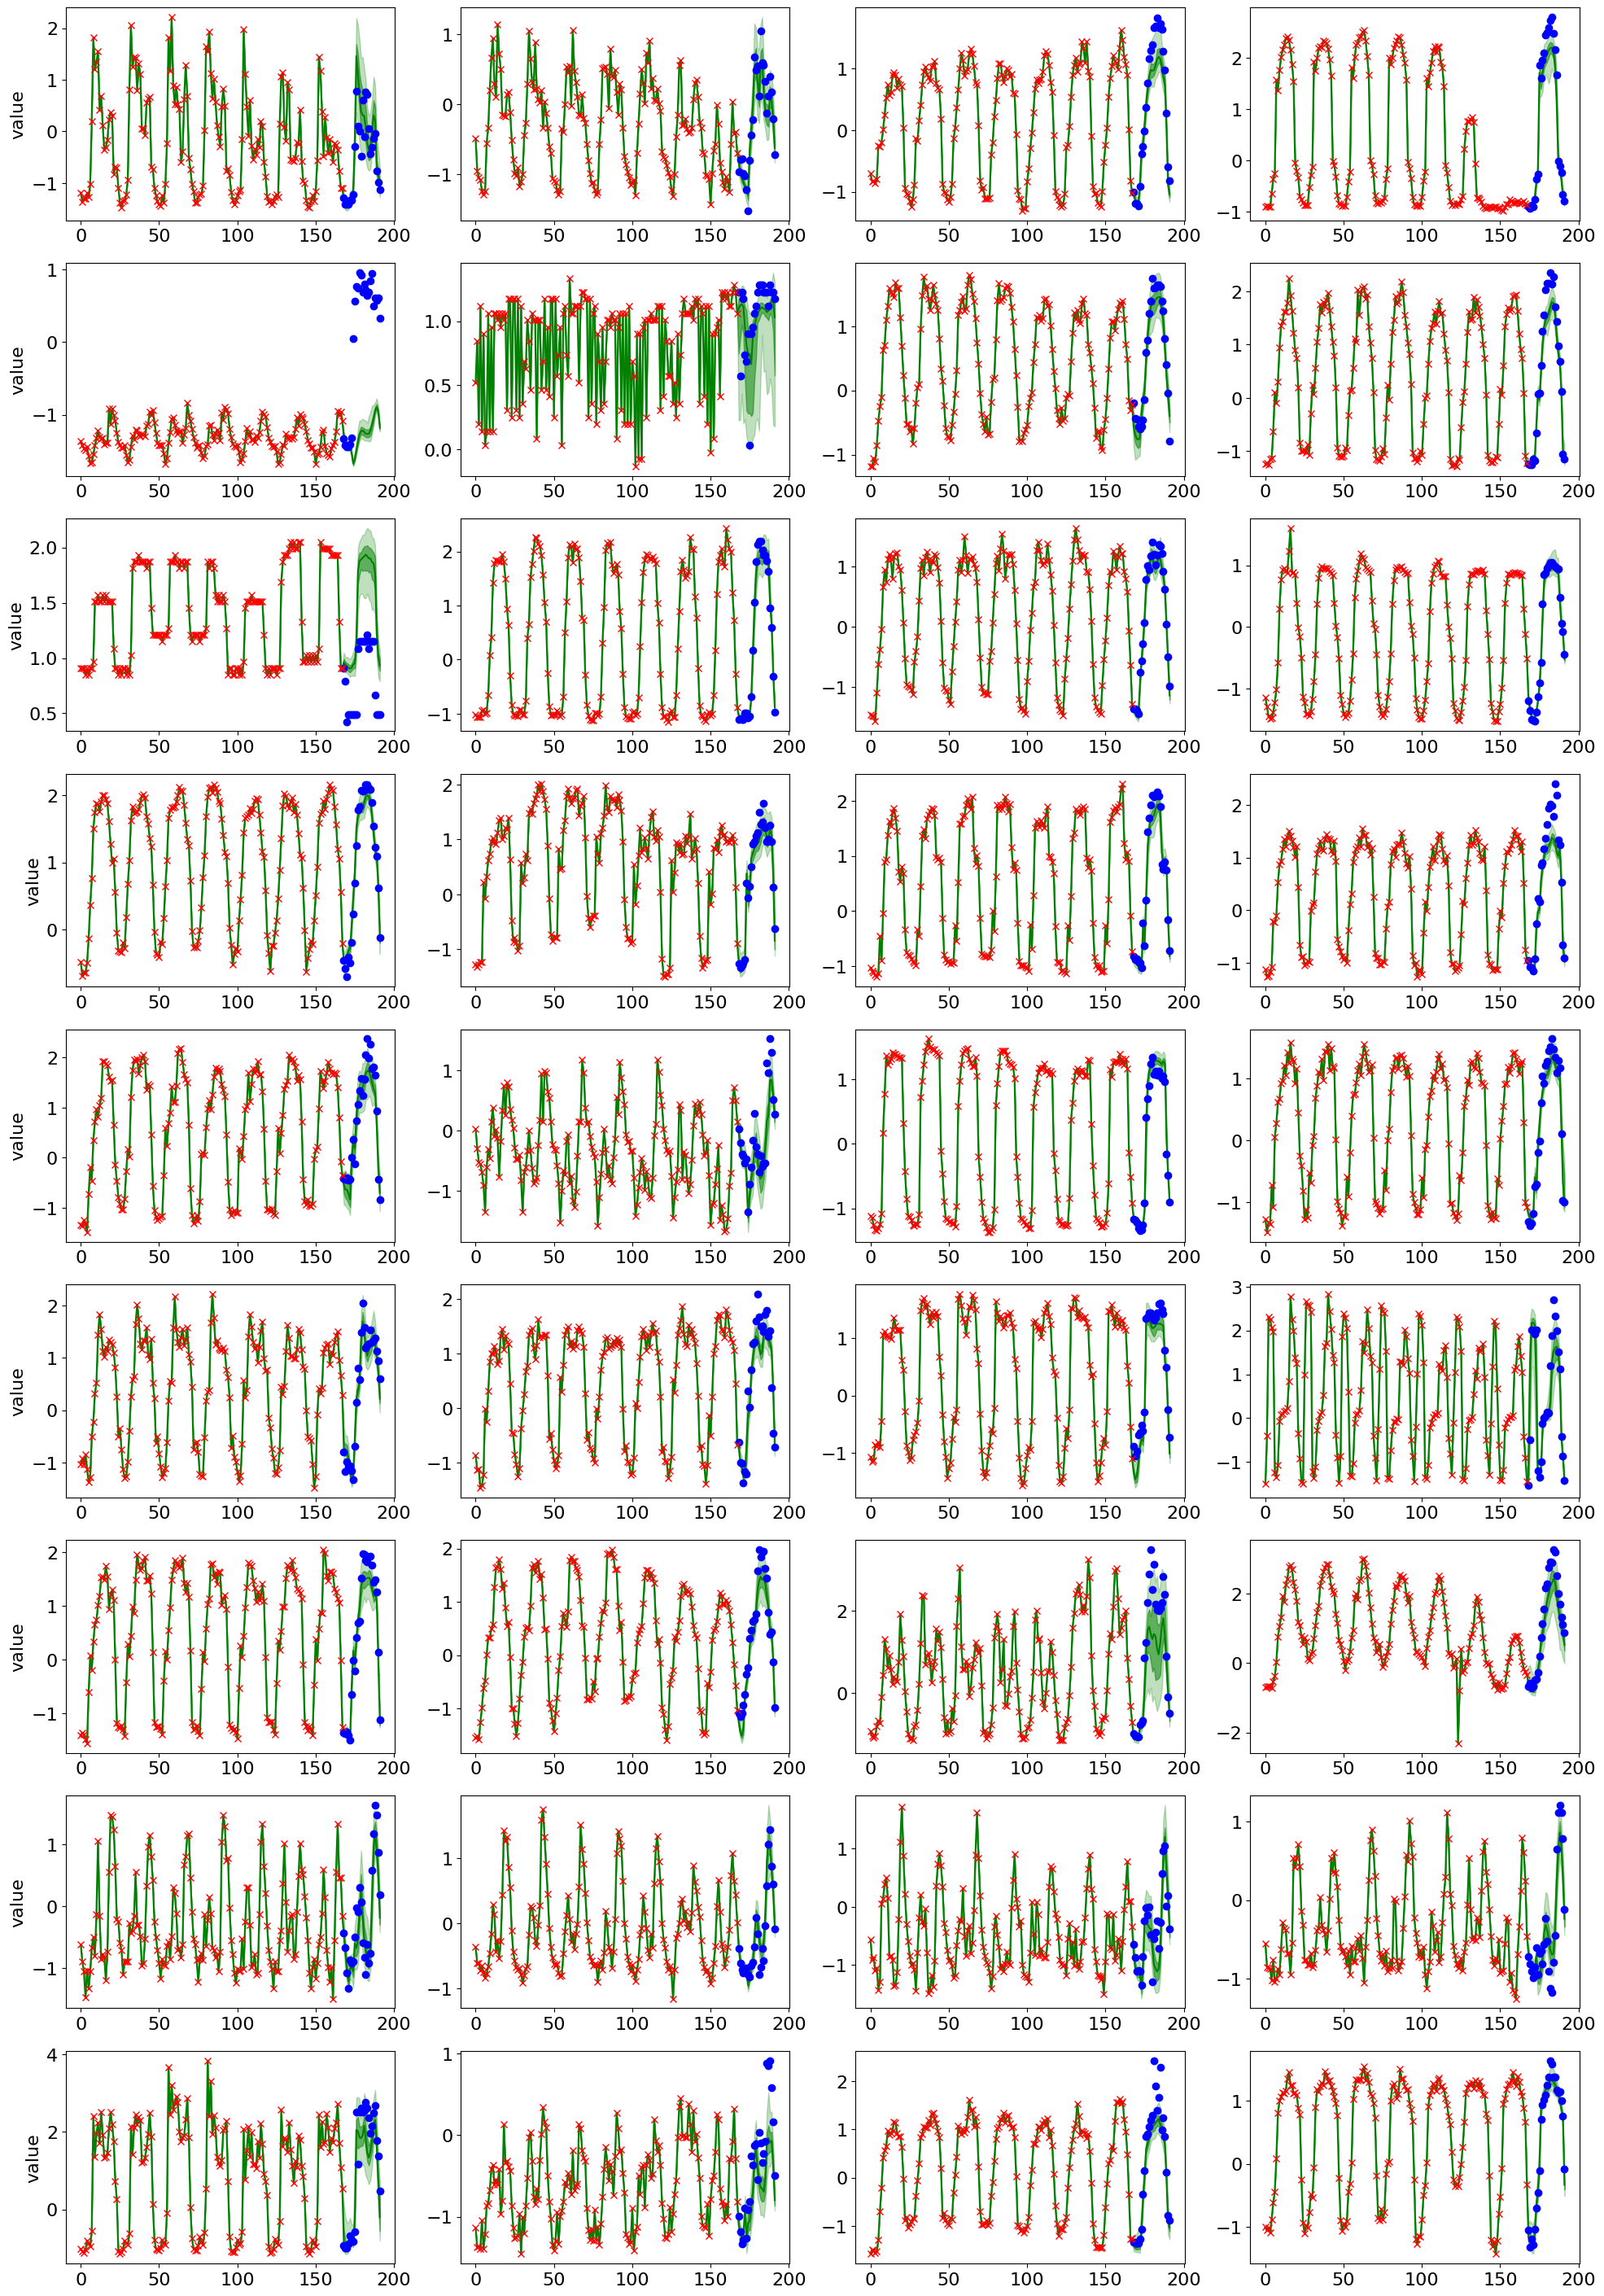

In [57]:
###electricity###
dataind = 0  # 0~6,表示一周的七天预测数据


plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4, figsize=(24.0, 36.0))


for k in range(K):
    df = pd.DataFrame(
        {
            "x": np.arange(0, L),
            "val": all_target_np[dataind, :, k],
            "y": all_evalpoint_np[dataind, :, k],
        }
    )
    df = df[df.y != 0]
    df2 = pd.DataFrame(
        {
            "x": np.arange(0, L),
            "val": all_target_np[dataind, :, k],
            "y": all_given_np[dataind, :, k],
        }
    )
    df2 = df2[df2.y != 0]
    row = k //4
    col = k % 4
    axes[row][col].plot(
        range(0, L),
        quantiles_imp[2][dataind, :, k],  # 0.5
        color="g",
        linestyle="solid",
        label="CSDI",
    )
    axes[row][col].fill_between(
        range(0, L),
        quantiles_imp[0][dataind, :, k],  # 0.05
        quantiles_imp[4][dataind, :, k],  # 0.95
        color="g",
        alpha=0.25,  # 透明度
    )
    axes[row][col].fill_between(
        range(0, L),
        quantiles_imp[1][dataind, :, k],  # 0.25
        quantiles_imp[3][dataind, :, k],  # 0.75
        color="g",
        alpha=0.5,  # 透明度
    )
    axes[row][col].plot(df.x, df.val, color="b", marker="o", linestyle="None")
    axes[row][col].plot(df2.x, df2.val, color="r", marker="x", linestyle="None")
    if col == 0:
        plt.setp(axes[row, 0], ylabel="value")
    if row == -1:
        plt.setp(axes[-1, col], xlabel="time")
"""

当row= k//4时: 下图共24个蓝点, 代表预测的一天24小时的结果
"""